In [1]:
import mitsuba as mi
mi.set_variant('scalar_rgb')
tent_rfilter = mi.load_dict({'type' : 'tent'})
mi.set_variant("cuda_ad_rgb")
import drjit as dr
from enum import Enum

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)

In [2]:
class Scene(Enum):
    COND1 = 1
    COND2 = 2

# Utils

In [3]:
def plot_res(images_bm, rough_bm, envlight_bm, titles, size_factor=3):
    fig, ax = plt.subplots(ncols=3, nrows=len(images_bm), figsize=(8, size_factor*len(images_bm)), squeeze=False)
    for i, (img, tex, envlight, title) in enumerate(zip(images_bm, rough_bm, envlight_bm, titles)):
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(tex)
        ax[i, 2].imshow(envlight)
        ax[i, 0].set_ylabel(title, size=14)
        ax[i, 0].set_xticks([]); ax[i, 0].set_yticks([])
        ax[i, 1].set_xticks([]); ax[i, 1].set_yticks([])
        ax[i, 2].set_xticks([]); ax[i, 2].set_yticks([])
    ax[0, 0].set_title("Rendering", weight='bold', size=14)
    ax[0, 1].set_title("Roughness texture", weight='bold', size=14)
    ax[0, 2].set_title("Environment light", weight='bold', size=14)
    plt.tight_layout()
    plt.show()

def plot_res2(res_dict, size_factor=3):
    titles = list(res_dict.keys())
    images_bm = [res_dict[title][0] for title in titles]
    textures_bm = [res_dict[title][1] for title in titles]
    envlights_bm = [res_dict[title][2] for title in titles]
    plot_res(images_bm, textures_bm, envlights_bm, titles, size_factor)

In [4]:
def image_to_bm(image):
    return mi.util.convert_to_bitmap(image)

def params_to_bm(params):
    return mi.util.convert_to_bitmap(params).convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, False)

In [5]:
def reset_scene(scene: Scene):
    return mi.load_file(f"../scenes/roughness_optimization_{scene.value}.xml")

# Reference scenes rendering

In [6]:
OPT_ROUGH_KEY = 'plane.bsdf.alpha.data'
OPT_ENVLIGHT_KEY = 'emitter.data'

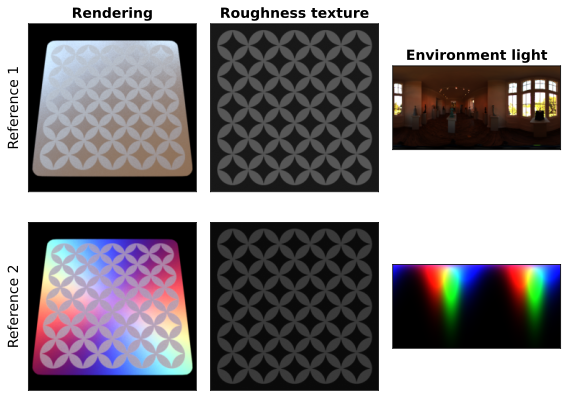

In [7]:
scene_ref = {k: reset_scene(k) for k in Scene}
params = {k: mi.traverse(scene_ref[k]) for k in Scene}

# Render reference images
image_ref = {k: mi.render(scene_ref[k], seed=0, spp=128) for k in Scene}
params_rough_ref = {k: params[k][OPT_ROUGH_KEY] for k in Scene}
params_envlight_ref = {k: params[k][OPT_ENVLIGHT_KEY] for k in Scene}

image_ref_bm = {k: image_to_bm(image_ref[k])  for k in Scene}
params_rough_ref_bm = {k: params_to_bm(params_rough_ref[k])  for k in Scene}
params_envlight_ref_bm = {k: params_to_bm(params_envlight_ref[k])  for k in Scene}

# Plot
plot_res2({f'Reference {k.value}': (image_ref_bm[k], params_rough_ref_bm[k], params_envlight_ref_bm[k]) for k in Scene})

# Optimization utils

In [8]:
def plot_losses(losses):
    plt.figure()
    for loss in losses:
        plt.semilogy(loss)
    plt.title("Loss convergence", weight='bold', size=14)
    plt.show()

In [9]:
def rel_l1_loss(img, img_ref):
    # Relative L1 loss
    return dr.sum(dr.abs(img - img_ref) / (dr.maximum(dr.abs(img_ref), 0.001))) / len(img)

def mse(img, img_ref):
    return dr.mean(dr.sqr(img - img_ref))

In [10]:
def run_opt_set_init(scene_name: Scene, init_values, optimizer_name="sgd", lr=120.0, loss_fn=rel_l1_loss, n_iterations = 100):
    # Optimization parameters
    spp_primal = 32
    spp_grad   = 4

    losses = []
    image_bm_init = []
    image_bm_end = []
    tex_bm_init = []
    tex_bm_end = []
    envlight_bm_init = []
    envlight_bm_end = []

    nb_opt_samples = len(init_values)

    for (opt_sample, (rough_init_values, envlight_init_values)) in enumerate(init_values):
        # Load scene
        scene = reset_scene(scene_name)

        params = mi.traverse(scene)
        params[OPT_ROUGH_KEY] = rough_init_values
        params[OPT_ENVLIGHT_KEY] = envlight_init_values
        params.update()

        # Standard stochastic gradient descent optimizer
        if optimizer_name.lower() == "sgd":
            opt = mi.ad.optimizers.SGD(lr=lr)
        elif optimizer_name.lower() == "adam":
            opt = mi.ad.optimizers.Adam(lr=lr)
        else:
            raise ValueError(f"Unknown optimizer {optimizer_name}")

        opt[OPT_ROUGH_KEY] = params[OPT_ROUGH_KEY]
        opt[OPT_ENVLIGHT_KEY] = params[OPT_ENVLIGHT_KEY]
        params.update(opt)

        losses.append([])
        for it in range(n_iterations):
            image = mi.render(scene, params, seed=it*nb_opt_samples + opt_sample, spp=spp_primal, spp_grad=spp_grad)

            if it == 0:
                image_bm_init.append(image_to_bm(image))
                tex_bm_init.append(params_to_bm(params[OPT_ROUGH_KEY]))
                envlight_bm_init.append(image_to_bm(params[OPT_ENVLIGHT_KEY]))
            
            # Apply loss function
            loss = loss_fn(image, image_ref[scene_name])

            # Backpropagate
            dr.backward(loss)

            # Optimizer: take a gradient step
            opt.step()
            opt[OPT_ROUGH_KEY] = dr.clamp(opt[OPT_ROUGH_KEY], 1e-2, 1.0)
            opt[OPT_ENVLIGHT_KEY] = dr.clamp(opt[OPT_ENVLIGHT_KEY], 0.0, 1.0)

            # Optimizer: Update the scene parameters
            params.update(opt)

            if it == n_iterations - 1:
                image_bm_end.append(image_to_bm(image))
                tex_bm_end.append(params_to_bm(params[OPT_ROUGH_KEY]))
                envlight_bm_end.append(image_to_bm(params[OPT_ENVLIGHT_KEY]))

            print(f'[Sample {opt_sample+1}/{nb_opt_samples}]  Iteration {it:03d}: loss={loss[0]:.5f}', end='\r')
            losses[opt_sample].append(loss)
    return {
        "losses": losses,
        "image_bm_init": image_bm_init,
        "image_bm_end": image_bm_end,
        "tex_bm_init": tex_bm_init,
        "tex_bm_end": tex_bm_end,
        "envlight_bm_init": envlight_bm_init,
        "envlight_bm_end": envlight_bm_end
    }

In [11]:
def generate_rand_rough_tex(scene_name: Scene, nb_opt_samples = 10):
    init_res = 32
    scale = 0.5 if scene_name == Scene.COND1 else 0.3
    opt_res = 128

    rough_values = []

    for opt_sample in range(nb_opt_samples):
        # Initialize textured roughness with random values
        np.random.seed(opt_sample)
        initial_values = mi.Bitmap((scale*np.random.uniform(size=init_res**2)).reshape(init_res, init_res, -1))

        # Upsample texture to full resolution
        upsampled_values = np.array(initial_values.resample([opt_res, opt_res], tent_rfilter))[..., np.newaxis]
        upsampled_values = mi.TensorXf(upsampled_values)

        rough_values.append(upsampled_values)

    return rough_values

In [12]:
def generate_rand_envlight(scene_name: Scene, nb_opt_samples = 10):
    init_res = 32
    scale = 0.5 if scene_name == Scene.COND1 else 0.3
    opt_res = 128

    envlight_values = []

    for opt_sample in range(nb_opt_samples):
        # Initialize textured roughness with random values
        np.random.seed(opt_sample)
        initial_values = mi.Bitmap((scale*np.random.uniform(size=2*init_res**2*4)).reshape(2*init_res, init_res, -1))

        # Upsample texture to full resolution
        upsampled_values = np.array(initial_values.resample([2*opt_res, opt_res], tent_rfilter))
        upsampled_values = mi.TensorXf(upsampled_values)

        envlight_values.append(upsampled_values)

    return envlight_values

In [13]:
def generate_rand_init_values(scene_name: Scene, nb_opt_samples = 10):
    rough_values = generate_rand_rough_tex(scene_name, nb_opt_samples)
    envlight_values = generate_rand_envlight(scene_name, nb_opt_samples)
    return list(zip(rough_values, envlight_values))

In [14]:
def plot_opt_results(results, scene_name: Scene, nb_results=2, size_factor=3):
    titles = [f"Initial {i}" for i in range(nb_results)] + [f"Final {i}" for i in range(nb_results)] + ["Reference"]
    images_bm = [results["image_bm_init"][i] for i in range(nb_results)] + [results["image_bm_end"][i] for i in range(nb_results)] + [image_ref_bm[scene_name]]
    textures_bm = [results["tex_bm_init"][i] for i in range(nb_results)] + [results["tex_bm_end"][i] for i in range(nb_results)] + [params_rough_ref_bm[scene_name]]
    envlights_bm = [results["envlight_bm_init"][i] for i in range(nb_results)] + [results["envlight_bm_end"][i] for i in range(nb_results)] + [params_envlight_ref_bm[scene_name]]
    plot_res2({titles[i]: (images_bm[i], textures_bm[i], envlights_bm[i]) for i in range(len(titles))}, size_factor=size_factor)

# Scene 1 + Adam + relative L1 loss

In [15]:
res = run_opt_set_init(Scene.COND1, generate_rand_init_values(Scene.COND1, nb_opt_samples=2), n_iterations=200, optimizer_name="adam", lr=1e-2, loss_fn=rel_l1_loss)

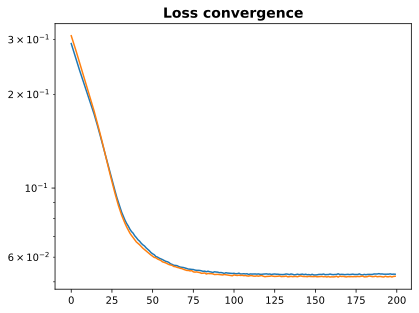

In [16]:
plot_losses(res["losses"])

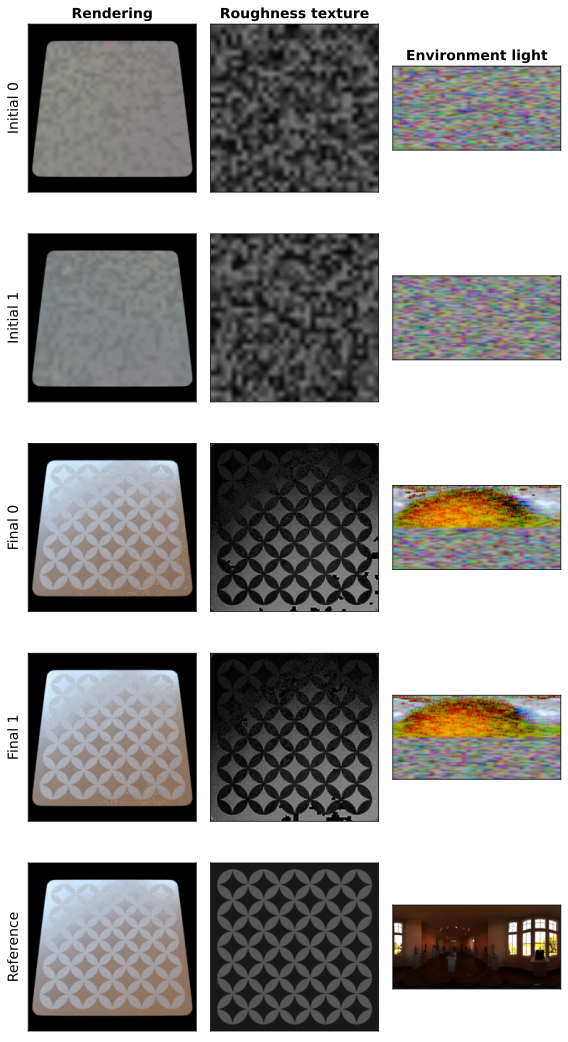

In [17]:
plot_opt_results(res, Scene.COND1, nb_results=2, size_factor=3)

# Scene 2 + Adam + relative L1 loss

In [18]:
res_ = run_opt_set_init(Scene.COND2, generate_rand_init_values(Scene.COND2, nb_opt_samples=2), n_iterations=200, optimizer_name="adam", lr=2e-2, loss_fn=rel_l1_loss)

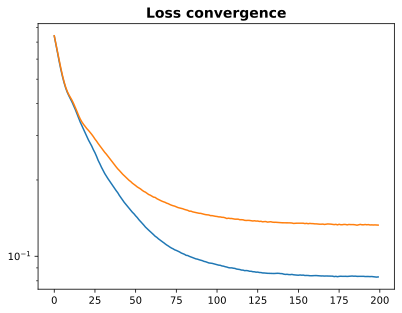

In [19]:
plot_losses(res_["losses"])

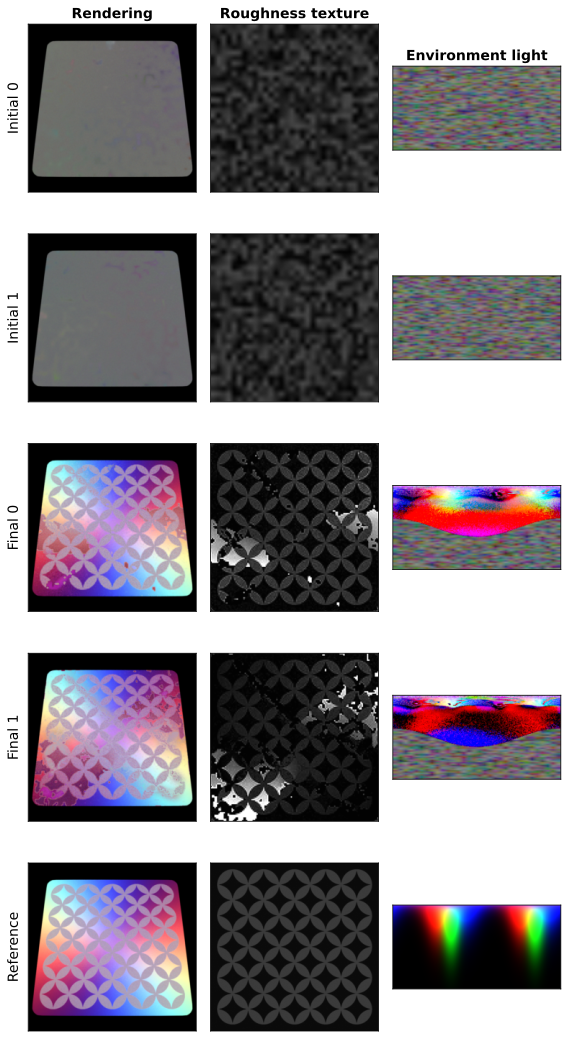

In [20]:
plot_opt_results(res_, Scene.COND2, nb_results=2, size_factor=3)

In [21]:
rand_rough = generate_rand_rough_tex(Scene.COND1, nb_opt_samples=1)[0]
envlight = mi.TensorXf(np.ones((128, 256, 3)))
res2 = run_opt_set_init(Scene.COND2, [(rand_rough, envlight)], n_iterations=200, optimizer_name="adam", lr=2e-2, loss_fn=rel_l1_loss)

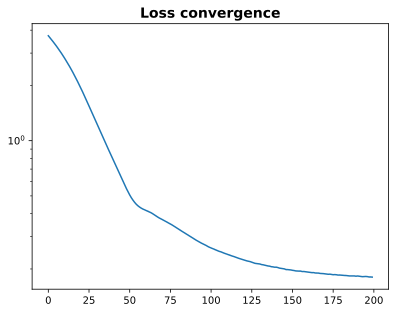

In [22]:
plot_losses(res2["losses"])

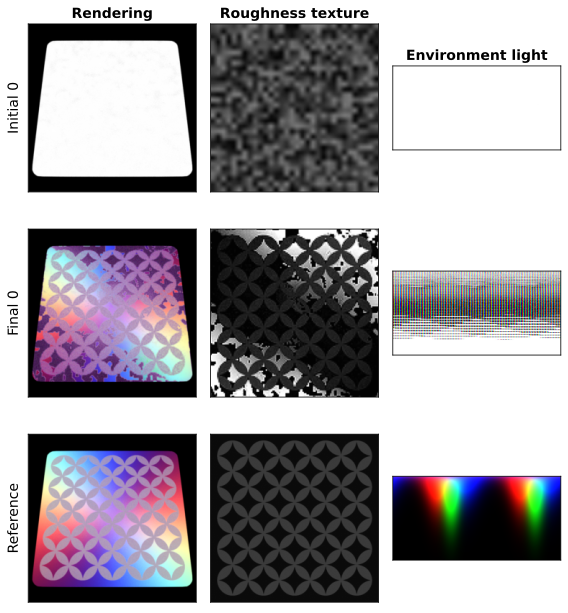

In [23]:
plot_opt_results(res2, Scene.COND2, nb_results=1, size_factor=3)

In [24]:
rand_rough = generate_rand_rough_tex(Scene.COND1, nb_opt_samples=1)[0]
envlight = mi.TensorXf(np.zeros((128, 256, 3)))
res2 = run_opt_set_init(Scene.COND2, [(rand_rough, envlight)], n_iterations=200, optimizer_name="adam", lr=2e-2, loss_fn=rel_l1_loss)

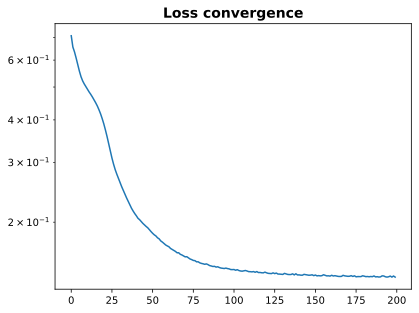

In [25]:
plot_losses(res2["losses"])

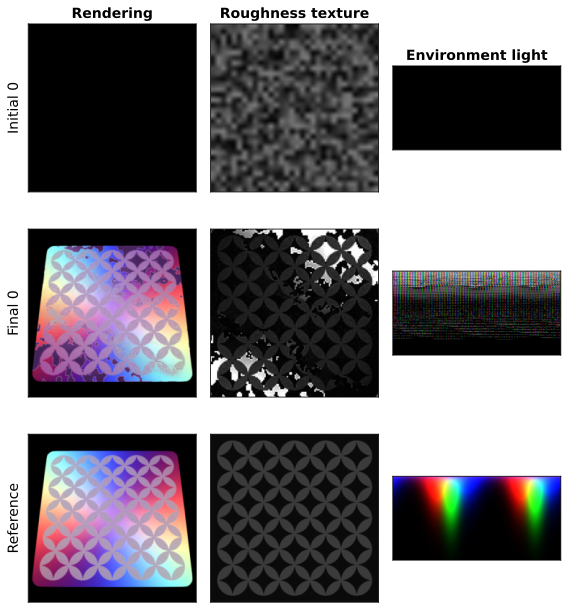

In [26]:
plot_opt_results(res2, Scene.COND2, nb_results=1, size_factor=3)